# MCMC samples from the true posterior for the CR model

Problem: Given an observed data set, generate MCMC samples from the posterior distribution.

Reason: This is needed in order to define a performance metric.

In [1]:
# Install dependencies

!pip install emcee corner --quiet

In [2]:
# Define problem

import numpy as np
from scipy.stats import norm
import emcee

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

# Demo dataset 1 (t=5: 0.4926555573669797)
param_prior = np.array([[-0.7, -0.9]])
result = [np.array([-0.02, 0.499, 0.57]), np.array([1, 2]), np.array([5., 10.])]

# Demo dataset 1'' 
param_prior = np.array([[-0.7, -0.9]])
result = [np.array([-0.02, 0.5, 0.57]), np.array([2]), np.array([10.])]

def log_prior(x,y):   
    # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
    return norm.logpdf(x,-0.75,0.25) + norm.logpdf(y,-0.75,0.25)

def log_likelihood(x,y):   
    # Calculates likelihood p(x_{1:N} | theta) by ignoring the missing data
    x = 10**x
    y = 10**y
    s = x + y
    b = x/s
    state_2 = lambda t: b - b * np.exp(-s*t)
    sol = state_2(result[2])
    residual = (result[0][result[1]] - sol)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return - nllh

def log_posterior(x,y):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return log_likelihood(x,y) + log_prior(x,y)

def log_posterior_v(x: np.ndarray):
    """Log-posterior with a single vector-valued argument."""
    x, y = x
    return log_posterior(x, y)



def sample(n_sample=10000, n_walker=10):
    """Perform sampling using emcee."""
    n_dim = 2
    p0 = np.random.randn(n_walker, n_dim)

    sampler = emcee.EnsembleSampler(n_walker, n_dim, log_posterior_v)
    sampler.run_mcmc(p0, n_sample)
    
    samples = sampler.get_chain(flat=True)
    return samples

In [3]:
%%time

# Sample
samples = sample(n_sample=1000)

# Posterior mean
np.mean(samples[:, 0]), np.mean(samples[:, 1])

CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.5 s


(-0.6432104969249682, -0.8038022365893867)

In [4]:
%%time

# Sample
samples = sample(n_sample=10000)

# Posterior mean
np.mean(samples[:, 0]), np.mean(samples[:, 1])

CPU times: user 14.6 s, sys: 0 ns, total: 14.6 s
Wall time: 14.6 s


(-0.6560005657175841, -0.8247013374849481)

In [5]:
%%time

# Sample
samples = sample(n_sample=50000)

# Posterior mean
np.mean(samples[:, 0]), np.mean(samples[:, 1])

CPU times: user 1min 16s, sys: 25.6 ms, total: 1min 16s
Wall time: 1min 16s


(-0.6574512017535142, -0.8250898246014968)

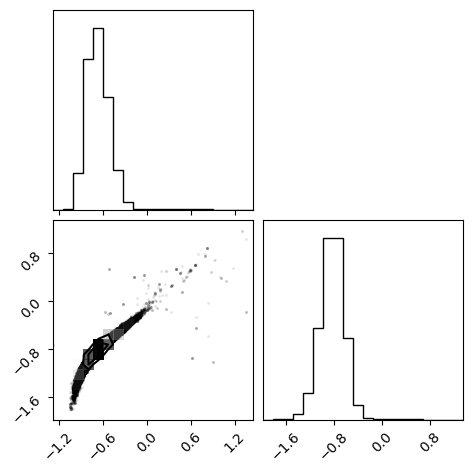

In [6]:
# Plot

import corner

fig = corner.corner(
    samples,
);